In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [133]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None 
        self.grad = 0 #derivative with respect to Loss, beginning we're assuming the weights don't affect the loss function
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other) #assume it's an integer or float
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other) #assume it's an integer or float
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    def __rmul__(self,other): #a * 2 works, but 2 * a doesn't work, because it's callign 2.__mul__(a), dosn't work, but python allows you to checck other way
        return self * other
    def tanh(self): #to help with hyperbolic functions, tanh(x) for ex
        n = self.data
        t = (math.exp(2 * n) - 1)/(math.exp(2 * n) + 1)
        out = Value(t, (self, ),'tanh')
        def _backward():
            self.grad +=  (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    def __radd__(self,other):
        return self + other
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += out.grad * (other * self.data ** (other - 1))
        out._backward = _backward
        return out
    def __truediv__(self, other): #self/other
        return self * other**-1
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a * b;e.label='e'
d = e + c;d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [57]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [3]:
#visualizer
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir' : 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
       dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

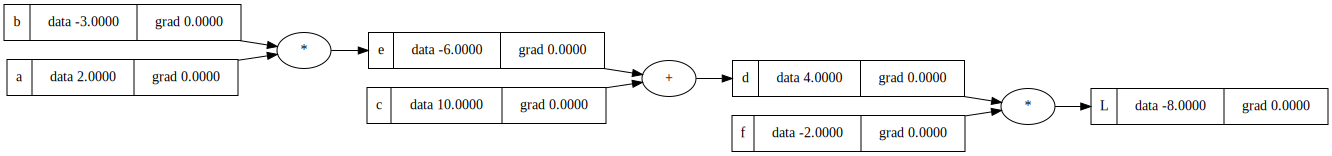

In [101]:
draw_dot(L)

In [34]:
#we're essentially interested in the change in the L, wrt the individual variables (or the weights in this case a, b, c, d, e, f, some of which will eventually 
#represent the weights
#some will be data, we don't care about change in those becasue they're fixed

In [59]:
#now dL/dc = dd/dc * dL/dd and dL/de = dd/de * dL/dd
#so we know dL/dd, what's dd/dc and dd/de? d = c + e, so dd/dc = 1.0, so dL/dc = -2
#dd/de = 1.0 as well, so dL/de = -2.0
e.grad = -2.0
c.grad = -2.0

In [60]:
#now dL/db = de/db * dd/de * dL/dd -> e = a * b so de/db = a = 2.0, dd/de = 1.0, dL/dd = -2.0, so product is -4.0
b.grad = -4.0
#now dL/da = de/da * dd/de * dL/dd -> e = a * b so de/da = b = -3.0, dd/de = 1.0, dL/dd = -2.0, product is 6.0
a.grad = 6.0

In [62]:
#now what we want is for L to go up, closer to zero. so let's nudge in the direction of the gradient to nudge L up
#why do you need to adjust all the weights? why not just one weight at a time?
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b 
d = e + c
L = d * f
print(L.data)


-7.286496


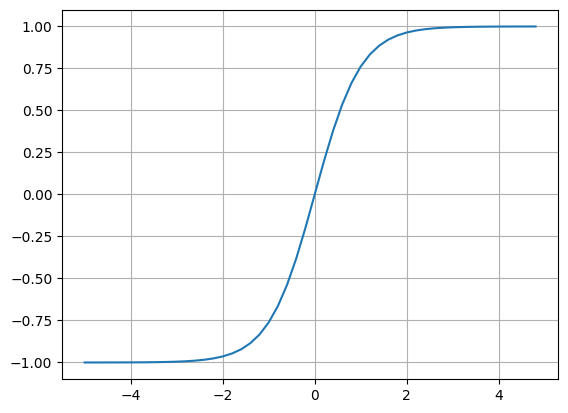

In [76]:
plt.plot(np.arange(-5,5,.2),np.tanh(np.arange(-5,5,.2))); plt.grid();

In [68]:
#Neural net
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')
#bias of neuron
b = Value(6.8813735870195432,label = 'b')
#x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o' #smooths it out, if we know deriv of tanh, then we can backpropagate
o.backward()

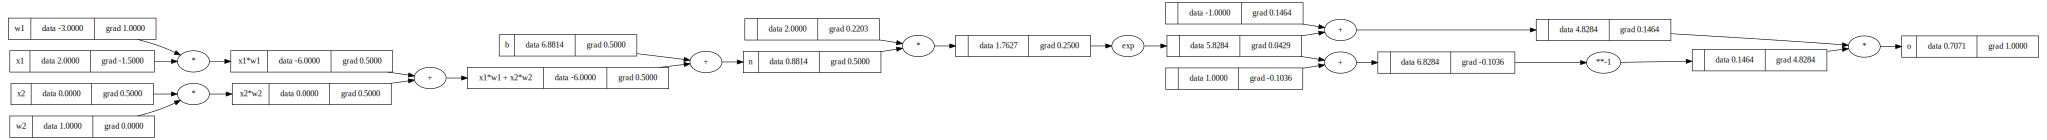

In [69]:
draw_dot(o)

In [19]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [70]:
o.backward()

In [24]:
#what if we don't have to manually call a bunch of backwards? use topological sort, but hide it in the class
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()

In [93]:
#backpropagating
o.grad = 1.0 
# o = tanh(n), derivative of tanh = 1 - tanh^2(x)
#do/dn = 1 - tanh(n) ** 2 = 1 - o** 2
n.grad = 1 - o.data ** 2
#+ is just distributor of gradient, so:
x1w1x2w2.grad = .5
b.grad = .5
x1w1.grad = .5
x2w2.grad = .5
#do/dx2 = dx2w2/dx2 * do/dx2w2 = w2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
#do/dx1 = dx1w1/dx1 * do/dx1w1 = w1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad
#do/dw1 = dx1w1/dw1 * do/dx1w1 = x1.data * x1w1.grad 
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad

In [71]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)
a + 1


Value(data=4.0)

In [80]:
import torch as t
import random

In [76]:
#let's get to pytorch
import torch as t
x1 = t.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = t.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = t.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = t.Tensor([1.0]).double() ; w2.requires_grad = True
b = t.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = t.tanh(n)
print(o.data.item())
o.backward()
print('---')
print('x2',x2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


In [273]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        #w * x + b, x is inputs for the neuron, takes in nin data points and multipled them to weight and then adds b
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b) 
        out = act.tanh() #activation function on the sum of w_i * x_i + b for final output
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer: 
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] #just list of neurons, each taking nin inputs, #of neurons in prev layer
        #nout is how many neurons are in this layer
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts #nin is how many neurons are going in and nouts is list for each layer, size of each layer
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))] #range(len(nouts)) because that's how many layers you have essentially
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.04646559340161241)

In [274]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [248]:
#so how to get them closer to ypred? calculate the loss 
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.342303719724163)

In [276]:
#forward pass
for k in range(500):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass, since loss is changing, update the grads
    for p in n.parameters():
        p.grad = 0 #so that it accumulates a new grads, not using grads from previous passes
    loss.backward()

    #update 
    for p in n.parameters():
        p.data += -.05 * p.grad #gradient descent, modifying in smal size step towards the gradient, think of grad as vector pointing into inc of loss
    print(k, loss.data)

0 0.0012012563886782308
1 0.0011982323771349997
2 0.001195222750062682
3 0.0011922274080645849
4 0.0011892462526387655
5 0.0011862791861681852
6 0.0011833261119109449
7 0.0011803869339906332
8 0.001177461557386886
9 0.0011745498879259645
10 0.0011716518322714923
11 0.0011687672979153415
12 0.0011658961931686077
13 0.00116303842715271
14 0.0011601939097905971
15 0.0011573625517980754
16 0.0011545442646752164
17 0.0011517389606979516
18 0.0011489465529096732
19 0.0011461669551130435
20 0.0011434000818618068
21 0.0011406458484527983
22 0.0011379041709179683
23 0.0011351749660165793
24 0.0011324581512274848
25 0.001129753644741441
26 0.0011270613654536185
27 0.001124381232956119
28 0.001121713167530663
29 0.0011190570901412659
30 0.0011164129224271156
31 0.0011137805866954754
32 0.0011111600059147055
33 0.0011085511037073196
34 0.00110595380434318
35 0.0011033680327327726
36 0.0011007937144205209
37 0.0010982307755782593
38 0.0010956791429986882
39 0.0010931387440889656
40 0.00109060950686

In [232]:
#minimize the loss!
loss.backward()

In [277]:
n.layers[0].neurons[0].w[2].grad
ypred

[Value(data=0.9906151760067765),
 Value(data=-0.9870917319808793),
 Value(data=-0.9928160393110488),
 Value(data=0.9854216266836152)]

In [235]:
for p in n.parameters():
    p.data -= -.1 * p.grad #gradient descent, modifying in smal size step towards the gradient, think of grad as vector pointing into inc of loss


In [278]:
len(n.parameters())

41